# 0-Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay, balanced_accuracy_score
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.optimizers import Adam
#from keras.backend import expand_dims
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.layers import Activation, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization, SpatialDropout1D

In [6]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# 1- Load Data

In [7]:
s_aureus = pd.read_csv('e_coli_driams_b_2000_20000Da_v2 (1).csv')
s_aureus.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19988,19991,19994,19997,code,species,Ciprofloxacin,Ceftriaxone,Cefepime,Piperacillin-Tazobactam
0,1067.142857,1251.714286,1310.571429,1021.142857,1315.625000,974.000000,936.857143,853.571429,936.142857,1044.285714,...,21.5,6.500000,4.666667,17.585859,dcd5aa31-b254-4961-b69f-ccc8c0572b27,Escherichia coli,0.0,0.0,0.0,0.0
1,1872.857143,1677.285714,2035.714286,2086.250000,1930.571429,2017.142857,1856.857143,1655.857143,1547.142857,1713.000000,...,21.0,15.000000,26.500000,21.736842,dfcb7221-e4f8-4a39-b661-7e439f19e93d,Escherichia coli,0.0,0.0,0.0,0.0
2,3258.142857,3209.428571,3068.571429,3162.428571,3275.000000,3324.571429,2999.000000,2970.500000,3213.000000,3205.571429,...,17.0,17.000000,30.000000,19.125000,d5bb4389-5053-4107-9c05-bfed9e9159c9,Escherichia coli,0.0,0.0,0.0,0.0
3,18912.571429,19530.571429,19464.875000,19098.714286,18994.714286,18936.285714,19208.571429,19417.571429,19486.857143,19048.625000,...,299.0,339.500000,359.000000,311.746032,4e14943f-ae22-42ed-aef5-65430470dcfa,Escherichia coli,0.0,0.0,0.0,0.0
4,1685.000000,1537.428571,1283.714286,1472.285714,1370.142857,1402.142857,1397.500000,1422.142857,1725.285714,3386.714286,...,32.5,48.333333,66.500000,39.230769,617f14d0-86b1-4c28-8995-b02006a85e81,Escherichia coli,1.0,1.0,1.0,1.0


# Preprocessing Data

In [8]:
s_aureus = s_aureus.drop(columns=['code','species', 'Ceftriaxone', 'Cefepime', 'Piperacillin-Tazobactam'])
s_aureus.dropna(axis=0, how="any", inplace=True)

In [9]:
s_aureus.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Ciprofloxacin
0,1067.142857,1251.714286,1310.571429,1021.142857,1315.625000,974.000000,936.857143,853.571429,936.142857,1044.285714,...,19.666667,20.000000,23.0,42.666667,15.000000,21.5,6.500000,4.666667,17.585859,0.0
1,1872.857143,1677.285714,2035.714286,2086.250000,1930.571429,2017.142857,1856.857143,1655.857143,1547.142857,1713.000000,...,32.000000,29.666667,30.0,18.000000,17.000000,21.0,15.000000,26.500000,21.736842,0.0
2,3258.142857,3209.428571,3068.571429,3162.428571,3275.000000,3324.571429,2999.000000,2970.500000,3213.000000,3205.571429,...,19.666667,20.000000,23.5,14.500000,13.666667,17.0,17.000000,30.000000,19.125000,0.0
3,18912.571429,19530.571429,19464.875000,19098.714286,18994.714286,18936.285714,19208.571429,19417.571429,19486.857143,19048.625000,...,299.000000,269.333333,282.0,300.500000,311.000000,299.0,339.500000,359.000000,311.746032,0.0
4,1685.000000,1537.428571,1283.714286,1472.285714,1370.142857,1402.142857,1397.500000,1422.142857,1725.285714,3386.714286,...,25.000000,34.000000,33.0,37.333333,21.000000,32.5,48.333333,66.500000,39.230769,1.0


In [10]:
bacteria = s_aureus.columns[-1]

In [11]:
X = s_aureus.iloc[:, 0:6000].values  # variables independientes (espectros de masa)
y = s_aureus.iloc[:, 6000].values    # variable dependientes (resistencia a ciprofloxacin)
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

In [12]:
s_aureus

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Ciprofloxacin
0,1067.142857,1251.714286,1310.571429,1021.142857,1315.625000,974.000000,936.857143,853.571429,936.142857,1044.285714,...,19.666667,20.000000,23.000000,42.666667,15.000000,21.500000,6.500000,4.666667,17.585859,0.0
1,1872.857143,1677.285714,2035.714286,2086.250000,1930.571429,2017.142857,1856.857143,1655.857143,1547.142857,1713.000000,...,32.000000,29.666667,30.000000,18.000000,17.000000,21.000000,15.000000,26.500000,21.736842,0.0
2,3258.142857,3209.428571,3068.571429,3162.428571,3275.000000,3324.571429,2999.000000,2970.500000,3213.000000,3205.571429,...,19.666667,20.000000,23.500000,14.500000,13.666667,17.000000,17.000000,30.000000,19.125000,0.0
3,18912.571429,19530.571429,19464.875000,19098.714286,18994.714286,18936.285714,19208.571429,19417.571429,19486.857143,19048.625000,...,299.000000,269.333333,282.000000,300.500000,311.000000,299.000000,339.500000,359.000000,311.746032,0.0
4,1685.000000,1537.428571,1283.714286,1472.285714,1370.142857,1402.142857,1397.500000,1422.142857,1725.285714,3386.714286,...,25.000000,34.000000,33.000000,37.333333,21.000000,32.500000,48.333333,66.500000,39.230769,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,1933.285714,1956.500000,2012.571429,1882.000000,1955.142857,1951.285714,1943.714286,2055.125000,1928.857143,1687.571429,...,140.500000,144.500000,102.666667,123.500000,113.500000,121.000000,126.666667,147.500000,122.560748,1.0
209,7296.714286,6215.714286,6115.500000,6069.000000,6585.857143,6207.857143,5809.142857,5879.142857,6068.714286,8413.125000,...,163.000000,191.500000,151.000000,180.666667,188.500000,163.500000,183.000000,173.000000,178.163462,1.0
210,2604.500000,2626.857143,2614.857143,2408.142857,2628.428571,2723.571429,2561.142857,2282.000000,2479.375000,2511.571429,...,21.000000,4.000000,11.500000,20.000000,19.500000,19.000000,10.500000,4.666667,13.857143,1.0
211,1341.142857,1190.000000,1399.142857,1469.000000,1126.000000,1049.428571,958.857143,1092.000000,1206.857143,1211.000000,...,18.000000,21.500000,15.666667,18.000000,18.000000,22.666667,17.500000,17.000000,20.863636,0.0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

## Enfoque en clase minoritaria

In [14]:
minority_class = s_aureus[s_aureus[bacteria] == 1].drop(columns=[bacteria])


In [15]:
etiquetas = s_aureus[s_aureus[bacteria] == 1].iloc[:, 6000].values

Vae

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()
X_minority_scaled = scaler.fit_transform(minority_class)

In [18]:
# Dimensiones
input_dim = X_minority_scaled.shape[1]
latent_dim = 2  # Espacio latente

# Encoder
inputs = Input(shape=(input_dim,))
hidden = Dense(16, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(hidden)
z_log_var = Dense(latent_dim, name='z_log_var')(hidden)

# Sampling
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Decoder
decoder_hidden = Dense(16, activation='relu')
decoder_output = Dense(input_dim, activation='sigmoid')

hidden_decoded = decoder_hidden(z)
outputs = decoder_output(hidden_decoded)

# Modelo VAE
vae = Model(inputs, outputs)

# Pérdida personalizada
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6000)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 16)           96016       ['input_1[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 2)            34          ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 2)            34          ['dense[0][0]']                  
                                                                                              

In [19]:
vae.fit(X_minority_scaled, X_minority_scaled, epochs=200, batch_size=32, verbose=1)


Epoch 1/200
2/2 [==============================] - 1s 8ms/step - loss: 644.9578
Epoch 2/200
2/2 [==============================] - 0s 9ms/step - loss: 647.8224
Epoch 3/200
2/2 [==============================] - 0s 9ms/step - loss: 638.4603
Epoch 4/200
2/2 [==============================] - 0s 9ms/step - loss: 626.5739
Epoch 5/200
2/2 [==============================] - 0s 9ms/step - loss: 616.0515
Epoch 6/200
2/2 [==============================] - 0s 10ms/step - loss: 613.9569
Epoch 7/200
2/2 [==============================] - 0s 9ms/step - loss: 602.2231
Epoch 8/200
2/2 [==============================] - 0s 9ms/step - loss: 599.1432
Epoch 9/200
2/2 [==============================] - 0s 10ms/step - loss: 604.4366
Epoch 10/200


2025-01-19 14:01:28.838287: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2/2 [==============================] - 0s 9ms/step - loss: 604.9300
Epoch 11/200
2/2 [==============================] - 0s 9ms/step - loss: 580.9978
Epoch 12/200
2/2 [==============================] - 0s 10ms/step - loss: 586.3425
Epoch 13/200
2/2 [==============================] - 0s 10ms/step - loss: 580.1727
Epoch 14/200
2/2 [==============================] - 0s 9ms/step - loss: 578.2284
Epoch 15/200
2/2 [==============================] - 0s 9ms/step - loss: 573.2711
Epoch 16/200
2/2 [==============================] - 0s 9ms/step - loss: 558.8557
Epoch 17/200
2/2 [==============================] - 0s 10ms/step - loss: 546.3057
Epoch 18/200
2/2 [==============================] - 0s 10ms/step - loss: 559.3060
Epoch 19/200
2/2 [==============================] - 0s 9ms/step - loss: 541.2289
Epoch 20/200
2/2 [==============================] - 0s 10ms/step - loss: 551.0278
Epoch 21/200
2/2 [==============================] - 0s 9ms/step - loss: 524.9634
Epoch 22/200
2/2 [==================

In [20]:
# Construir el generador (Decoder independiente)
decoder_input = Input(shape=(latent_dim,))
hidden_decoded_2 = decoder_hidden(decoder_input)
output_decoded = decoder_output(hidden_decoded_2)
generator = Model(decoder_input, output_decoded)

# Generar datos sintéticos
num_samples = pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1]
latent_points = np.random.normal(size=(num_samples, latent_dim))
synthetic_data = generator.predict(latent_points)

# Escalar de vuelta a los valores originales
synthetic_data_original = scaler.inverse_transform(synthetic_data)


3/3 [==============================] - 0s 2ms/step


In [21]:
pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1]

76

In [22]:
print(pd.Series(y_train).value_counts())

0.0    123
1.0     47
Name: count, dtype: int64


In [23]:
synthetic_data_original

array([[2756.1562  , 2698.6995  , 2714.7808  , ...,   68.72281 ,
          69.19042 ,   67.84134 ],
       [2594.6597  , 2572.5332  , 2563.78    , ...,   64.92577 ,
          65.42639 ,   64.068306],
       [3068.3816  , 2952.999   , 3062.0625  , ...,  103.62955 ,
         101.64045 ,   98.33969 ],
       ...,
       [2875.9392  , 2796.0383  , 2838.363   , ...,   82.15847 ,
          81.49235 ,   79.75677 ],
       [3394.6992  , 3199.0615  , 3354.5154  , ...,  115.60014 ,
         110.957794,  110.41377 ],
       [3187.6306  , 3038.7844  , 3148.4072  , ...,   95.762726,
          94.40454 ,   92.198555]], dtype=float32)

In [24]:
X_train_balanced = np.concatenate([X_train, synthetic_data_original])
y_train_balanced = np.concatenate([y_train, np.ones(num_samples)])


In [25]:
print(pd.Series(y_train_balanced).value_counts())

0.0    123
1.0    123
Name: count, dtype: int64


In [26]:
synthetic_data

array([[0.27138337, 0.29016206, 0.2626909 , ..., 0.15415987, 0.16196379,
        0.15851036],
       [0.25167564, 0.27244955, 0.24374984, ..., 0.14520812, 0.15261216,
        0.14873667],
       [0.30948487, 0.32586327, 0.3062528 , ..., 0.23645473, 0.24258497,
        0.23751344],
       ...,
       [0.28600076, 0.3038275 , 0.27819267, ..., 0.18583529, 0.19252758,
        0.18937615],
       [0.34930608, 0.36040804, 0.34293717, ..., 0.26467618, 0.26573366,
        0.26879022],
       [0.32403708, 0.3379067 , 0.31708363, ..., 0.2179082 , 0.22460756,
        0.22160542]], dtype=float32)

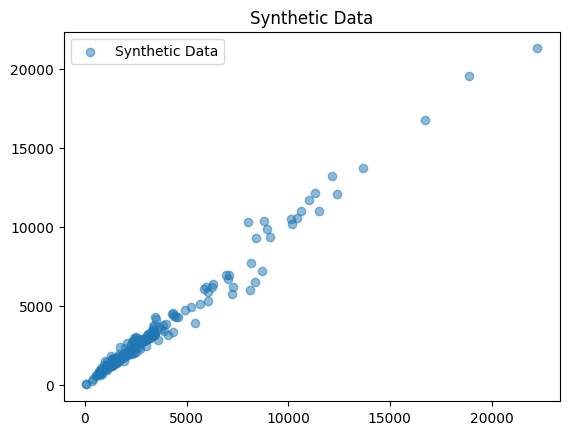

In [27]:
# Visualización
#plt.scatter(minority_class['feature1'], minority_class['feature2'], alpha=0.5, label='Original Data')
plt.scatter(X_train_balanced[:, 0], X_train_balanced[:, 1], alpha=0.5, label='Synthetic Data')
plt.legend()
plt.title('Synthetic Data')
plt.show()

## Termino oversampling

In [28]:
len(X)

213

In [29]:
len(X_train)

170

In [30]:
len(y_train)

170

In [31]:
scaler=Normalizer(norm='max')
sc_X = scaler
X_train = sc_X.fit_transform(X_train_balanced)
X_test = sc_X.transform(X_test)

In [32]:
sample_size = X_train.shape[0] # numero de muestras en el set de datos
time_steps  = X_train.shape[1] # numero de atributos en el set de datos
input_dimension = 1            #

X_train_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [33]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)
early_st = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

n_timesteps = X_train_reshaped.shape[1] #
n_features  = X_train_reshaped.shape[2] #

In [34]:
print(pd.Series(y_train_balanced).value_counts())


0.0    123
1.0    123
Name: count, dtype: int64


# Create and fit DeepAMR model

In [35]:
model = Sequential(name="Modelo_s_aureus_ciprofloxacin")
init_mode = 'normal'
model.add(Conv1D(filters=(64), kernel_size=(17), input_shape = (n_timesteps,n_features), name='Conv_1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_1"))

model.add(Conv1D(filters=(128), kernel_size=(9),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name='Conv_2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_2"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode,kernel_regularizer=regularizers.l2(0.0001),   name='Conv_3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_3"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),   name='Conv_4'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_4"))

model.add(Flatten())
model.add(Dropout(0.65))
model.add(Dense(256, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_0"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_1"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name="fully_connected_2"))
model.add(Dense(n_features, activation='sigmoid', name="OUT_Layer"))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy',  metrics=METRICS)
model.summary()

Model: "Modelo_s_aureus_ciprofloxacin"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv1D)             (None, 5984, 64)          1152      
                                                                 
 batch_normalization (BatchN  (None, 5984, 64)         256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 5984, 64)          0         
                                                                 
 MaxPooling1D_1 (MaxPooling1  (None, 2992, 64)         0         
 D)                                                              
                                                                 
 Conv_2 (Conv1D)             (None, 2984, 128)         73856     
                                                                 
 batch_normalization_1 (Batc  (None, 

In [36]:
history = model.fit(X_train_reshaped, y_train_balanced, epochs=100, batch_size=10, verbose=1, validation_split=0.1, callbacks=[reduce_lr,early_st])

Epoch 1/100


2025-01-19 14:01:37.735090: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907
2025-01-19 14:01:37.759964: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


23/23 [==============================] - 4s 72ms/step - loss: 7.1778 - tp: 52.0000 - fp: 50.0000 - tn: 73.0000 - fn: 46.0000 - accuracy: 0.5656 - precision: 0.5098 - recall: 0.5306 - auc: 0.5546 - prc: 0.5295 - val_loss: 6.8397 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 25.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 1.0000 - lr: 1.0000e-04
Epoch 2/100
23/23 [==============================] - 1s 29ms/step - loss: 6.6385 - tp: 61.0000 - fp: 25.0000 - tn: 98.0000 - fn: 37.0000 - accuracy: 0.7195 - precision: 0.7093 - recall: 0.6224 - auc: 0.7636 - prc: 0.7219 - val_loss: 6.8502 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 25.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 1.0000 - lr: 1.0000e-04
Epoch 3/100
23/23 [==============================] - 1s 30ms/step - loss: 6.5804 - tp: 62.0000 -

# Evaluate the model

In [37]:
y_pred  = model.predict(X_test_reshaped)
y_pred = (y_pred>0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)

2/2 [==============================] - 0s 30ms/step
[[31  0]
 [12  0]]


In [38]:
print("balanced acuracy:", balanced_accuracy_score(y_test, y_pred))

balanced acuracy: 0.5


In [39]:
target_names=["0","1"]
print(classification_report(y_test, y_pred, target_names=target_names))

train_predictions_baseline = model.predict(X_train_reshaped, batch_size=10)
test_predictions_baseline = model.predict(X_test_reshaped, batch_size=10)

baseline_results = model.evaluate(X_test_reshaped, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

              precision    recall  f1-score   support

           0       0.72      1.00      0.84        31
           1       0.00      0.00      0.00        12

    accuracy                           0.72        43
   macro avg       0.36      0.50      0.42        43
weighted avg       0.52      0.72      0.60        43

12/25 [=============>................] - ETA: 0s

/home/hpinto/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hpinto/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hpinto/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 [==============================] - 0s 9ms/step
loss :  6.750918388366699
tp :  0.0
fp :  0.0
tn :  31.0
fn :  12.0
accuracy :  0.7209302186965942
precision :  0.0
recall :  0.0
auc :  0.5
prc :  0.3095978796482086



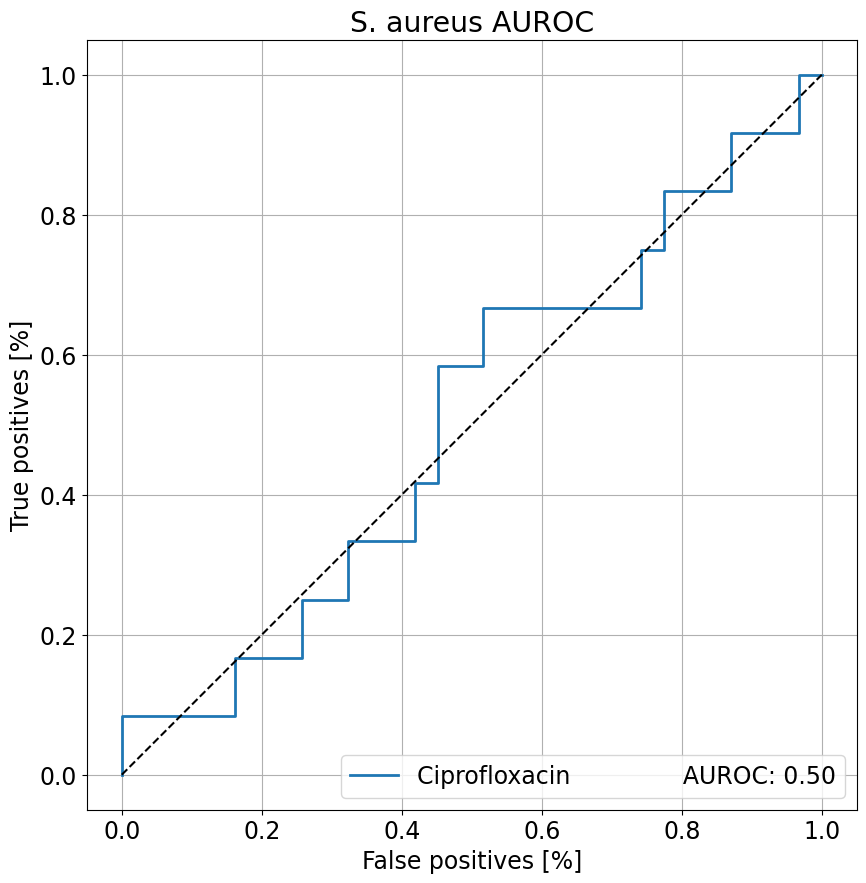

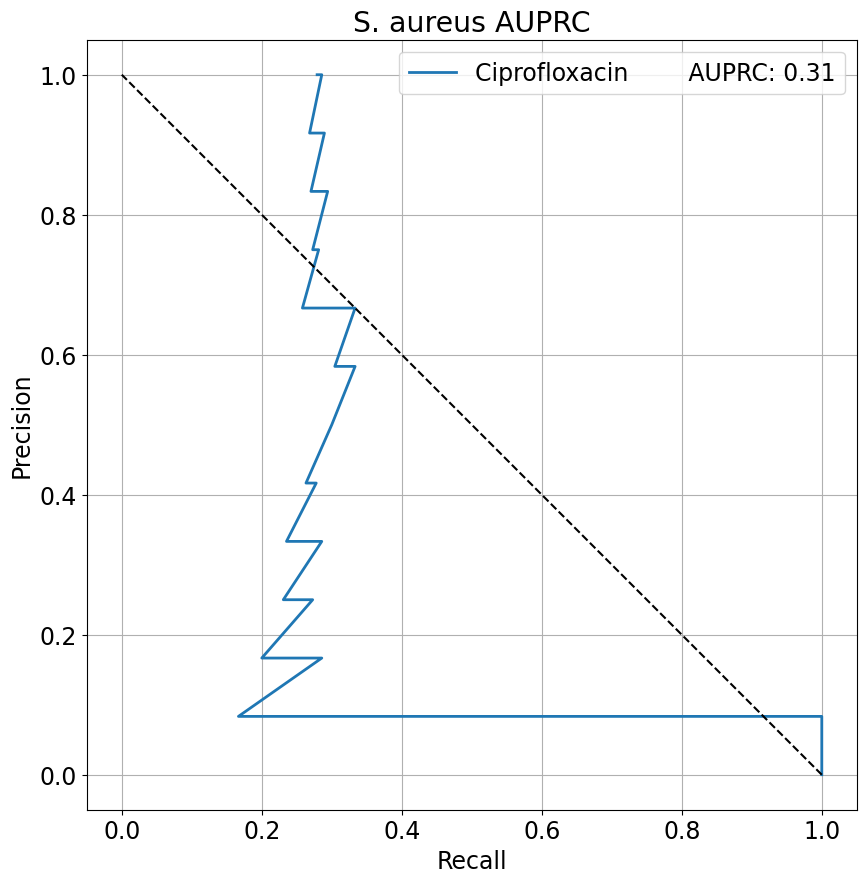

In [40]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams.update({'font.size': 17})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.title('E. coli CNN')
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.title('S. aureus AUROC')

  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
plot_roc("Ciprofloxacin               AUROC: %0.2f" % baseline_results[8], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='lower right')
plt.savefig('s_aureus_auroc.png', bbox_inches='tight')
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.title('S. aureus AUPRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([1, 0], [0, 1], 'k--')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Ciprofloxacin        AUPRC: %0.2f" % baseline_results[9], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='upper right')
plt.savefig('s_aureus_auprc.png', bbox_inches='tight')
plt.show()